<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/LassoSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import logit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style

In [3]:
# Import dependence variable
odr = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/monthlyODR.csv'
)

# Select segment, drop columns
odr = odr.query(
    "Segment == 'CU'"
).drop(
    ['Segment', 'Monthkey'],
    axis = 1
).eval(
    "ODR = Bad / N"
)

# Transform to logit
odr['logitODR'] = logit(odr['ODR'])

# Import macroeconomics data
mev = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroTransformed.csv'
)

# Assign date to dependence variable
odr['Date'] = mev['Date']
odr.head(5)

,N,Bad,ODR,logitODR,Date
0,21556,815.0,0.037808,-3.236680,2014-01-01
1,21794,885.0,0.040608,-3.162347,2014-02-01
2,21911,920.0,0.041988,-3.127475,2014-03-01
3,22128,960.0,0.043384,-3.093313,2014-04-01
4,22115,989.0,0.044721,-3.061565,2014-05-01


In [4]:
# Mapping with logit ODR
df = pd.merge(
    odr[['Date', 'logitODR']],
    mev,
    how = 'left',
    left_on = ['Date'],
    right_on = ['Date']
)
df = df.set_index('Date')

In [5]:
# Target and features split
X = df.drop(['logitODR'], axis = 1)
y = df['logitODR']

In [6]:
# Standardisation data
scaler = StandardScaler()
XStd = pd.DataFrame(
    scaler.fit_transform(X),
    columns = X.columns
)
XStd.head(5)

,FDI,HD,GDP,RSI,CPI,Wage,UR,OP,Im,Ex,...,MPI_C_lg3,MPI_C_lg4,MPI_C_lg5,MPI_C_lg6,MPI_C_lg7,MPI_C_lg8,MPI_C_lg9,MPI_C_lg10,MPI_C_lg11,MPI_C_lg12
0,-1.215493,-1.734971,-0.562899,-0.570916,-0.768418,-1.956620,-0.297957,2.004780,1.534546,-1.089160,...,-1.357261,-0.581567,-0.195384,-0.061058,0.776930,1.262120,2.218458,3.172031,2.518157,4.160491
1,-0.980961,-1.712674,-0.457205,-0.887732,-0.465585,-2.237374,-0.756054,2.069397,-1.480127,-0.840170,...,-2.332102,-1.336999,-0.564333,-0.176136,-0.053107,0.768618,1.204361,2.016637,3.017261,2.069820
2,-0.778302,-1.694352,-0.531350,0.417949,-0.200606,-2.723591,-0.641530,2.003850,-0.169171,0.081482,...,-2.126566,-2.312629,-1.329325,-0.549574,-0.169179,-0.057255,0.726310,1.079681,1.910317,2.491427
3,-0.647592,-1.654295,-0.806451,-0.937728,0.430297,-1.107049,-0.527006,2.021980,-0.044833,-1.758306,...,-2.649950,-2.106926,-2.317301,-1.323875,-0.545841,-0.172744,-0.073705,0.637996,1.012653,1.556360
4,-0.579062,-1.597924,-1.176492,-0.492502,0.947637,-0.982668,-0.297957,2.109841,0.780497,-0.126449,...,-1.308532,-2.630734,-2.108996,-2.323873,-1.326826,-0.547516,-0.185578,-0.101162,0.589489,0.798076


In [7]:
# Lasso features selection
'''
By default, the penalty (alpha) is 0 means there is no penalty term.
This will be equal to linear regression.
The more alpha value, the more selection strict.
Resulting in less variables are passed.
'''
selectedAlpha = 0.01 #Default alpha = 1 is too strong --> Set 0.01 first 

# Select from model
selector = SelectFromModel(
    Lasso(alpha = selectedAlpha)
)
selector.fit(XStd, y) #Fit with all data

SelectFromModel(estimator=Lasso(alpha=0.01))

In [8]:
# Result
selectedVar = X.columns[(selector.get_support())] #Return index as True
print(f'Total selected features: {len(selectedVar)}\n')
print(f'Selected features:\n{selectedVar}')

Total selected features: 12

Selected features:
Index(['FDI_C', 'CPI_M9_lg4', 'UR_C_lg6', 'GDP_C_lg11', 'GDP_C_lg12',
       'Ex_C_lg1', 'Ex_C_lg2', 'API_C_lg8', 'API_C_lg9', 'API_C_lg10',
       'MPI_C_lg11', 'MPI_C_lg12'],
      dtype='object')


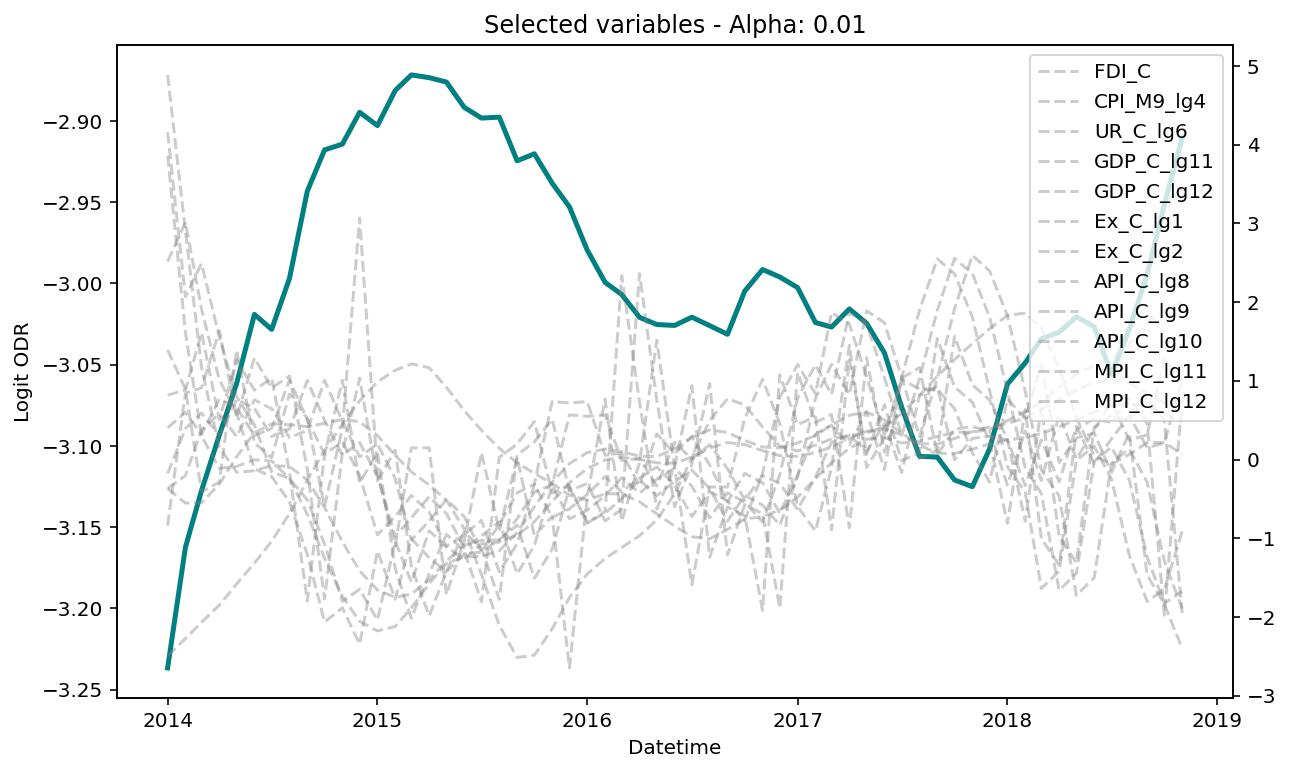

In [9]:
# Define plot function
def plotSelect(XData, yData, title):
  plt.figure(figsize = (10, 6))
  plt.title(f'{title} - Alpha: {selectedAlpha}')
  plt.xlabel('Datetime')
  plt.ylabel('Logit ODR')
  plt.plot(
    pd.to_datetime(y.index),
    yData,
    c = 'teal',
    linewidth = 2.5
  )
  plt.twinx()
  for var in selectedVar:
    plt.plot(
        pd.to_datetime(X.index),
        XData[var],
        c = 'gray',
        linestyle = '--',
        label = var,
        alpha = 0.4
    )
    plt.legend(
      frameon = True,
      facecolor = 'white',
      loc = 1
  )
  return plt.show()

# Plot
plotSelect(XStd, y, 'Selected variables')

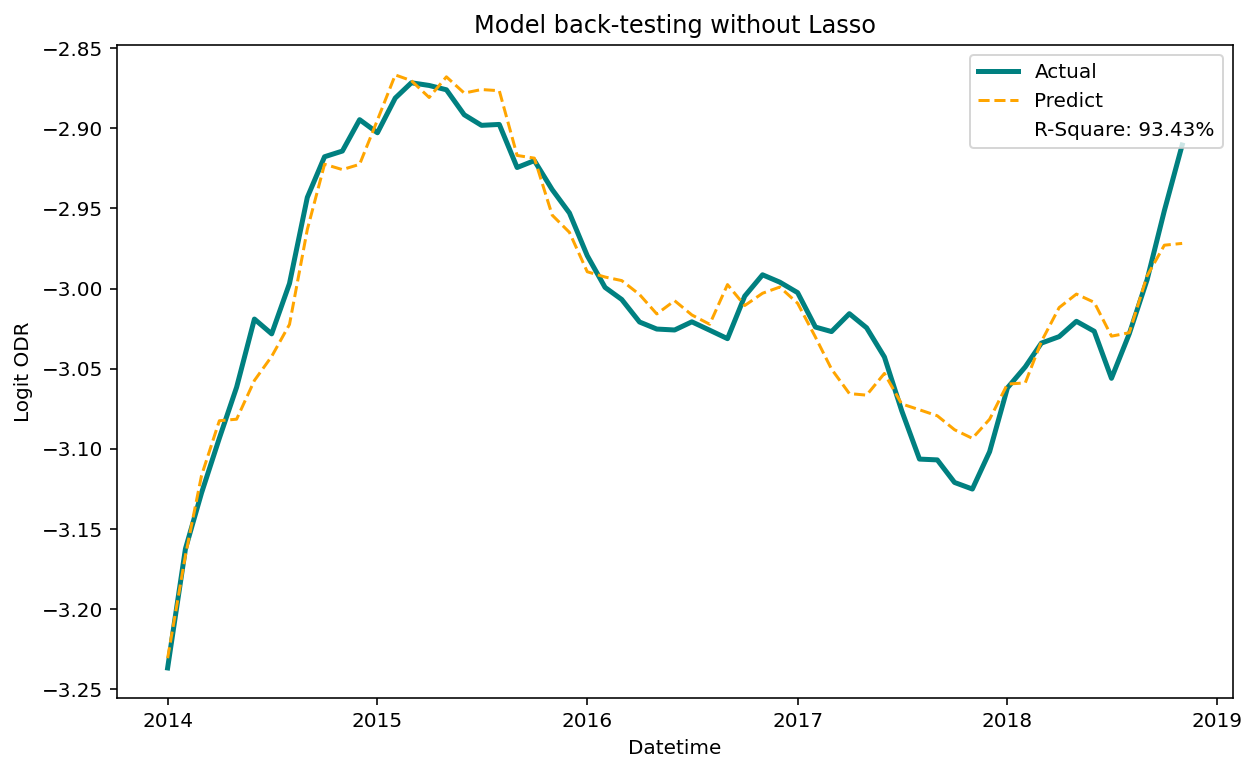

In [10]:
# Define back-testing function
def backTesting(title):
  # Fitting with linear regression
  model = LinearRegression()
  model.fit(X[selectedVar], y)
  # Plot
  plt.figure(figsize = (10, 6))
  plt.title(title)
  plt.xlabel('Datetime')
  plt.ylabel('Logit ODR')
  plt.plot(
      pd.to_datetime(y.index),
      y,
      c = 'teal',
      linewidth = 2.5,
      label = 'Actual'
  )
  plt.plot(
      pd.to_datetime(y.index),
      model.predict(X[selectedVar]),
      c = 'orange',
      linestyle = '--',
      label = 'Predict'
  )
  plt.plot([], [], color = 'white', label = f'R-Square: {model.score(X[selectedVar], y) * 100:.2f}%')
  plt.legend(frameon = True, facecolor = 'white', loc = 1)
  return plt.show()

# Plot
backTesting('Model back-testing without Lasso')

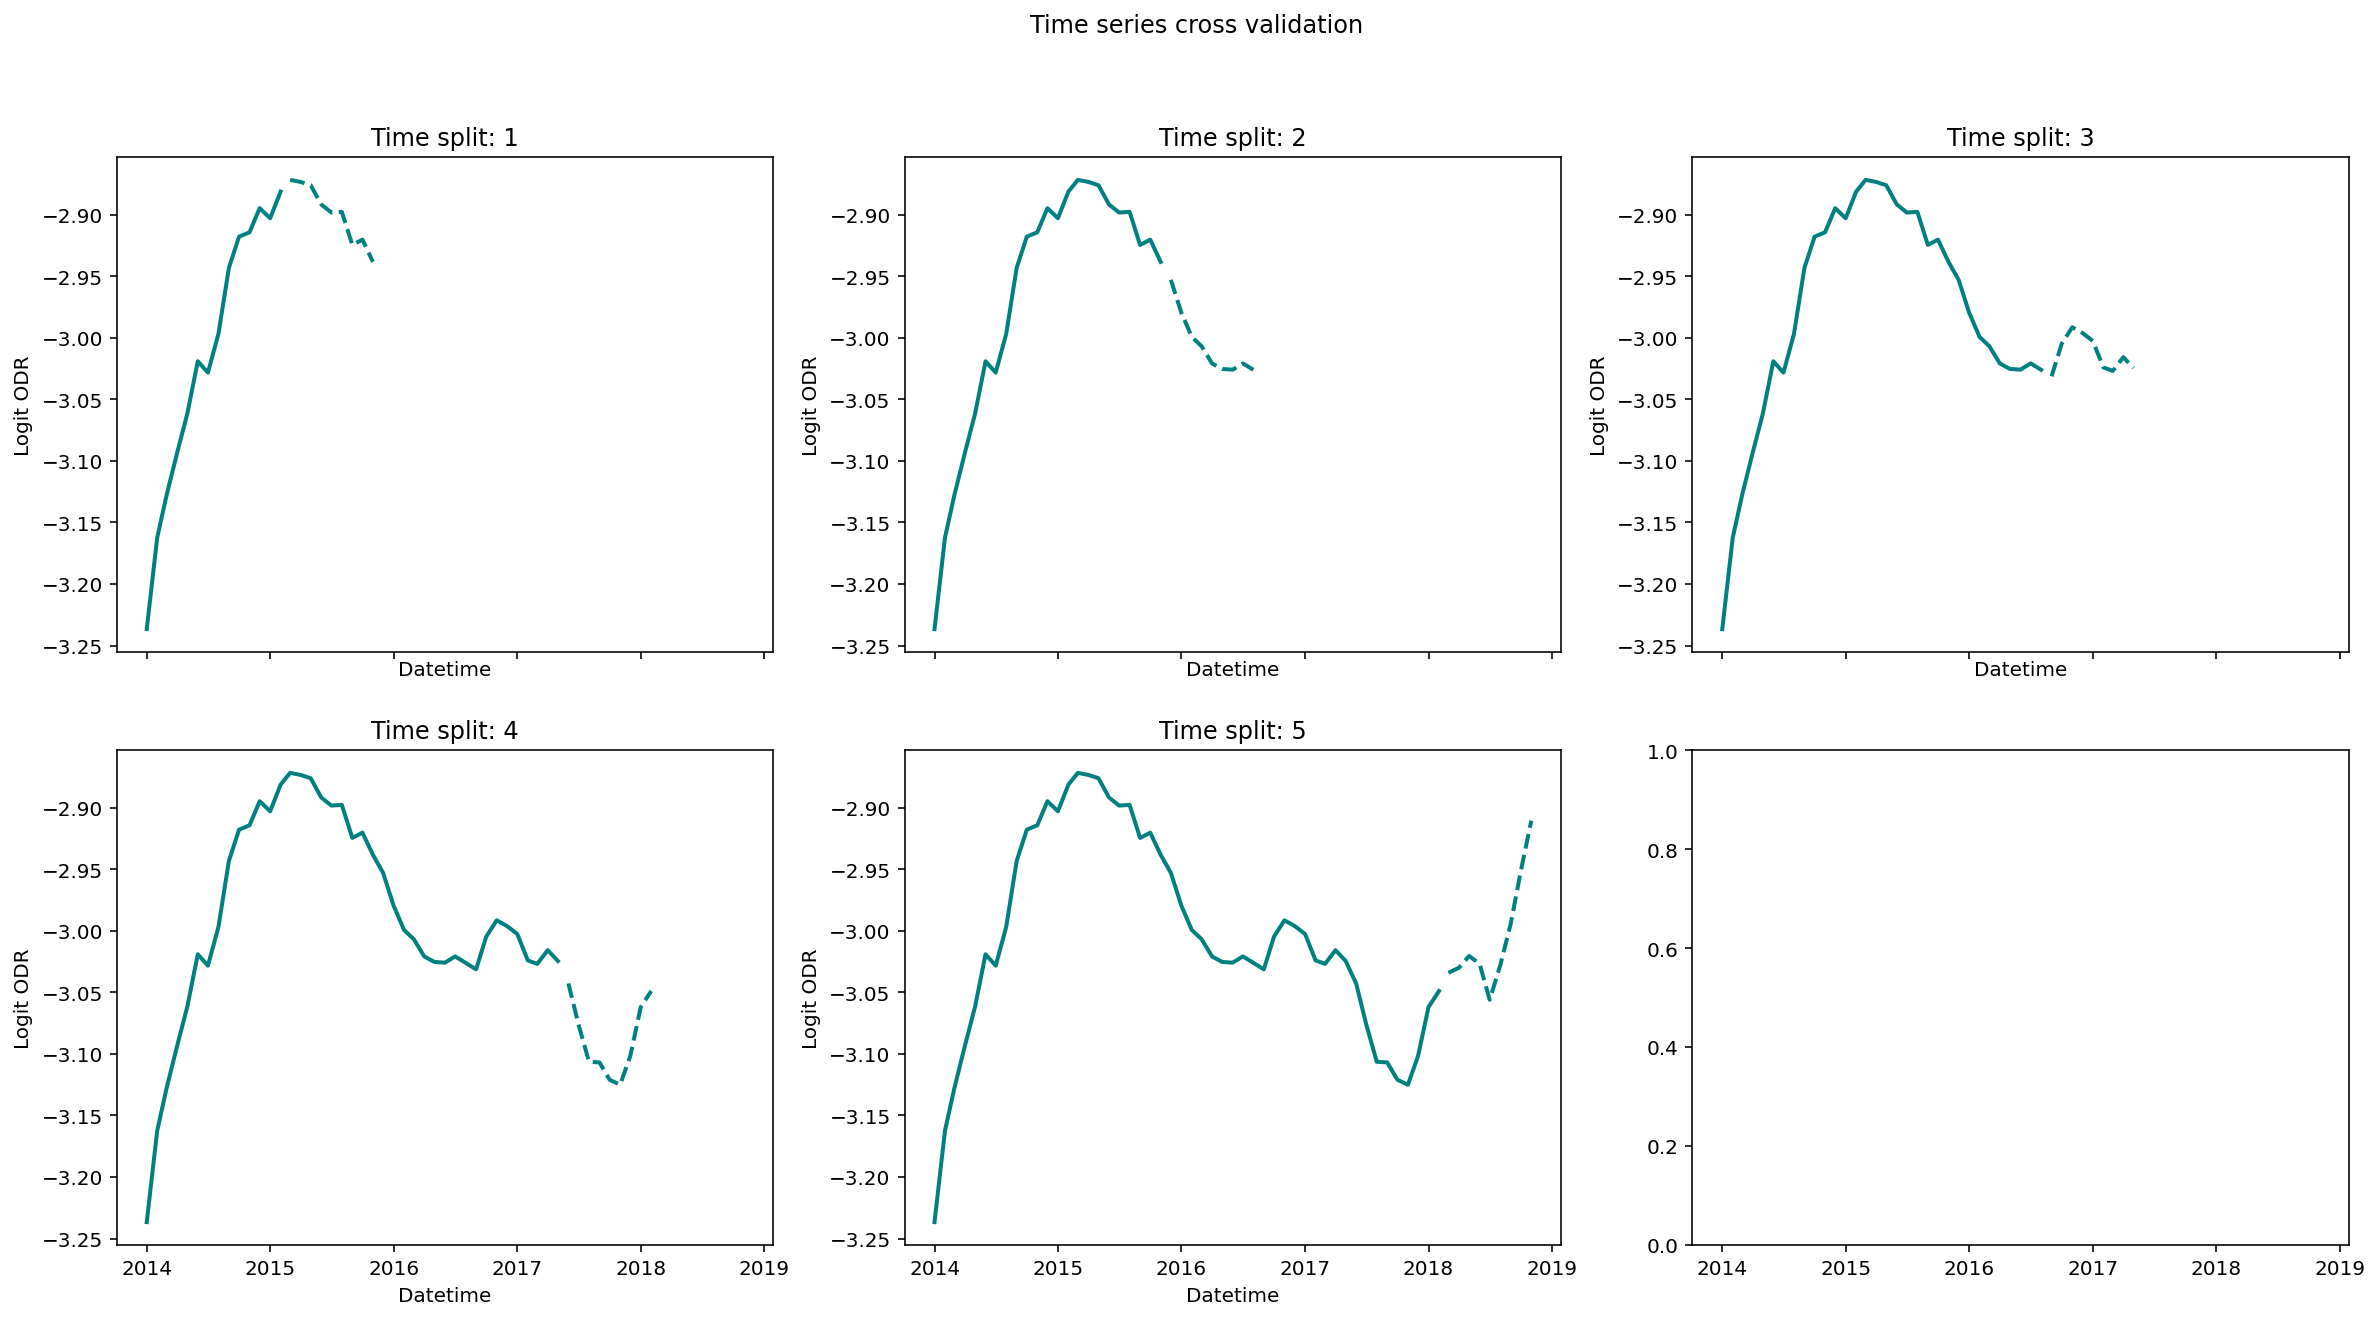

In [11]:
# Time series cross validation
TSCV = TimeSeriesSplit(n_splits = 5)

# Plot
fig, axs = plt.subplots(2, 3, figsize = (20, 10), sharex = True)
fig.suptitle('Time series cross validation')
axs = axs.ravel()

for i, (trainIndex, testIndex) in zip(range(TSCV.get_n_splits()), TSCV.split(XStd)):
  # Train/Test split
  yTrain, yTest = y.iloc[trainIndex], y.iloc[testIndex]
  # Plot
  axs[i].set_title(f'Time split: {i + 1}')
  axs[i].plot(
      pd.to_datetime(yTrain.index),
      yTrain,
      color = 'teal',
      linewidth = 2
  )
  axs[i].plot(
      pd.to_datetime(yTest.index),
      yTest,
      color = 'teal',
      linewidth = 2, 
      linestyle = '--'
  )
  axs[i].set(xlabel = 'Datetime', ylabel = 'Logit ODR')
plt.show()

In [12]:
# Hyperparameter tuning
alphas = np.linspace(0.001, 0.1, 100) #Define range of alphas
model = Lasso() #Lasso regression model
paramSearch = {
    'alpha': alphas
}

# GridSearchCV
gridSearch = GridSearchCV(
    estimator = model,
    cv = TSCV,
    param_grid = paramSearch,
    scoring = 'neg_mean_absolute_percentage_error',
    n_jobs = -1
)

# Fit
gridSearch.fit(XStd, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.0...
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  ])},
             scoring='neg_mean_absolute_percentage_error')

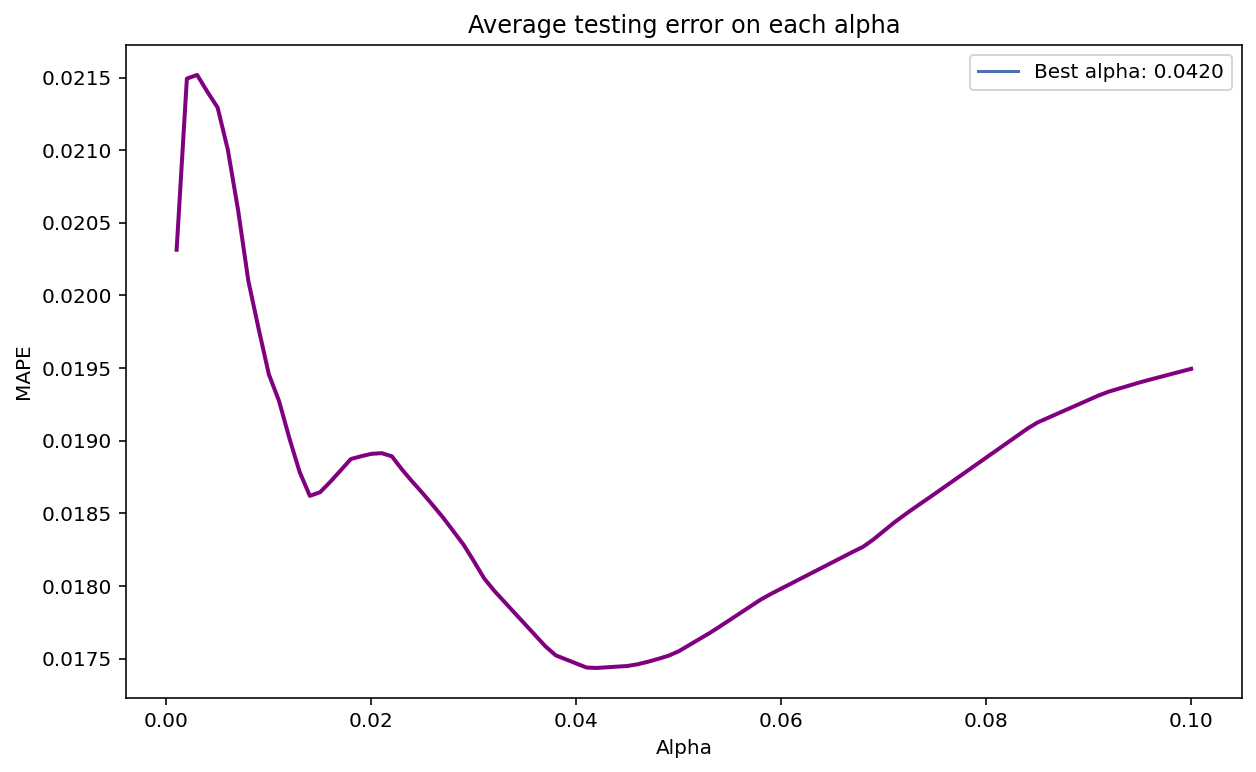

In [13]:
# Plot
plt.figure(figsize = (10, 6))
plt.title('Average testing error on each alpha')
plt.xlabel('Alpha')
plt.ylabel('MAPE')
plt.plot(
    alphas,
    gridSearch.cv_results_['mean_test_score'] * -1,
    c = 'purple',
    linewidth = 2
)
plt.plot([], [], label = f"Best alpha: {gridSearch.best_params_['alpha']:.4f}")
plt.legend(frameon = True, facecolor = 'white', loc = 1)
plt.show()

In [14]:
# New selection with best alpha
selectedAlpha = gridSearch.best_params_['alpha']

# Select from model
selector = SelectFromModel(
    Lasso(alpha = selectedAlpha)
)
selector.fit(XStd, y) #Fit with all data

SelectFromModel(estimator=Lasso(alpha=0.042))

In [15]:
# Result
selectedVar = X.columns[(selector.get_support())] #Return index as True
print(f'Total selected features: {len(selectedVar)}\n')
print(f'Selected features:\n{selectedVar}')

Total selected features: 3

Selected features:
Index(['GDP_C_lg11', 'GDP_C_lg12', 'MPI_C_lg12'], dtype='object')


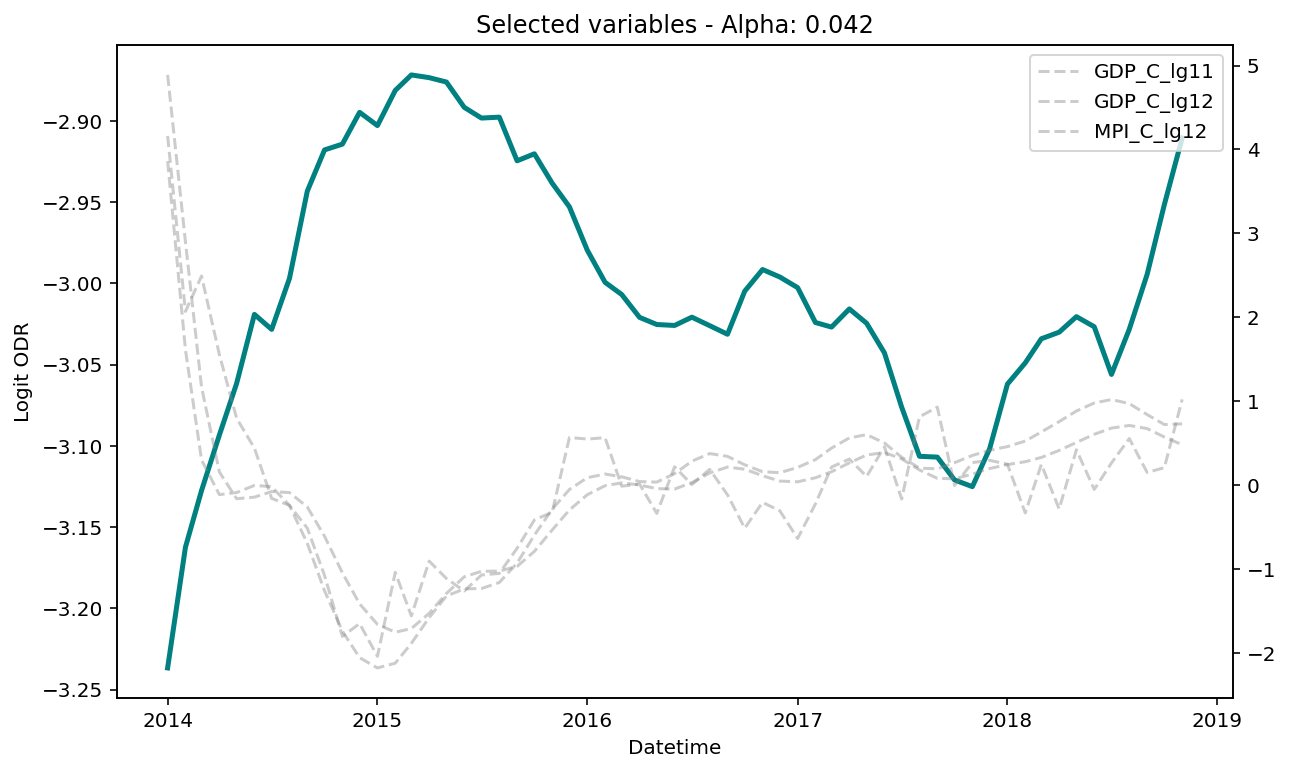

In [16]:
# Plot
plotSelect(XStd, y, 'Selected variables')

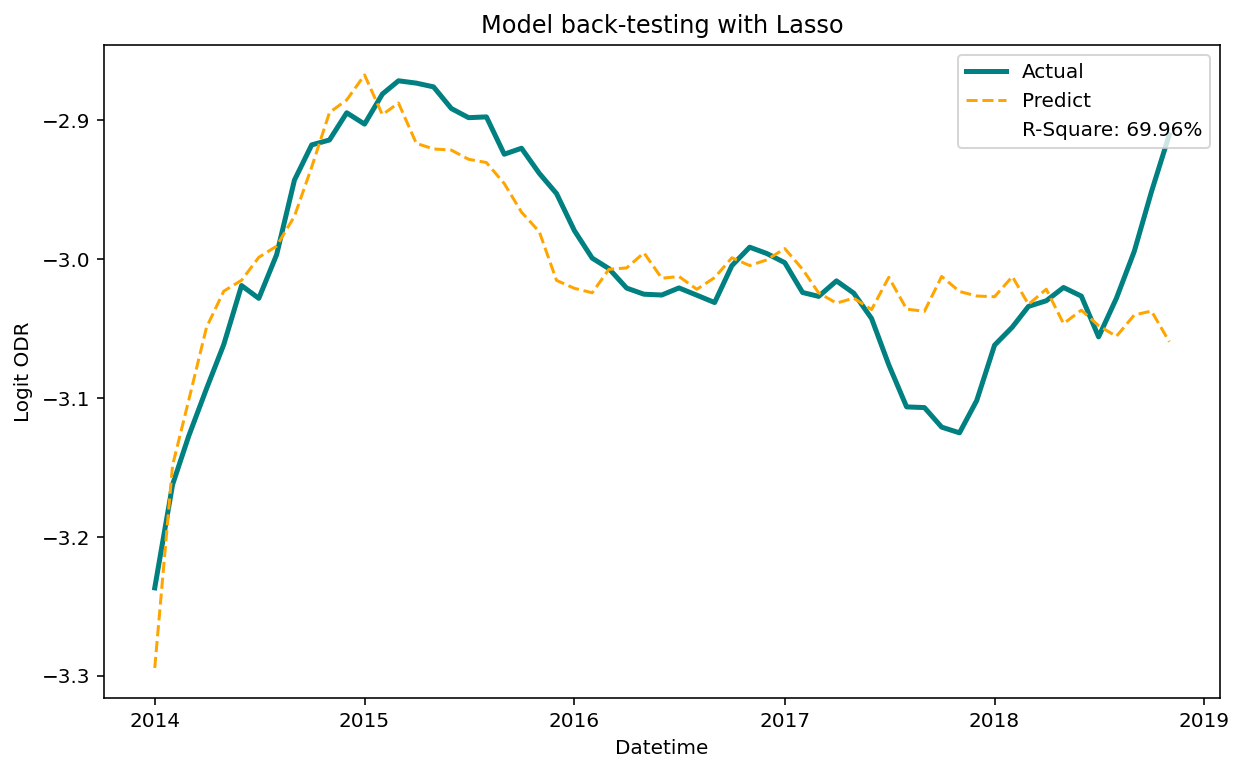

In [17]:
# Plot
backTesting('Model back-testing with Lasso')

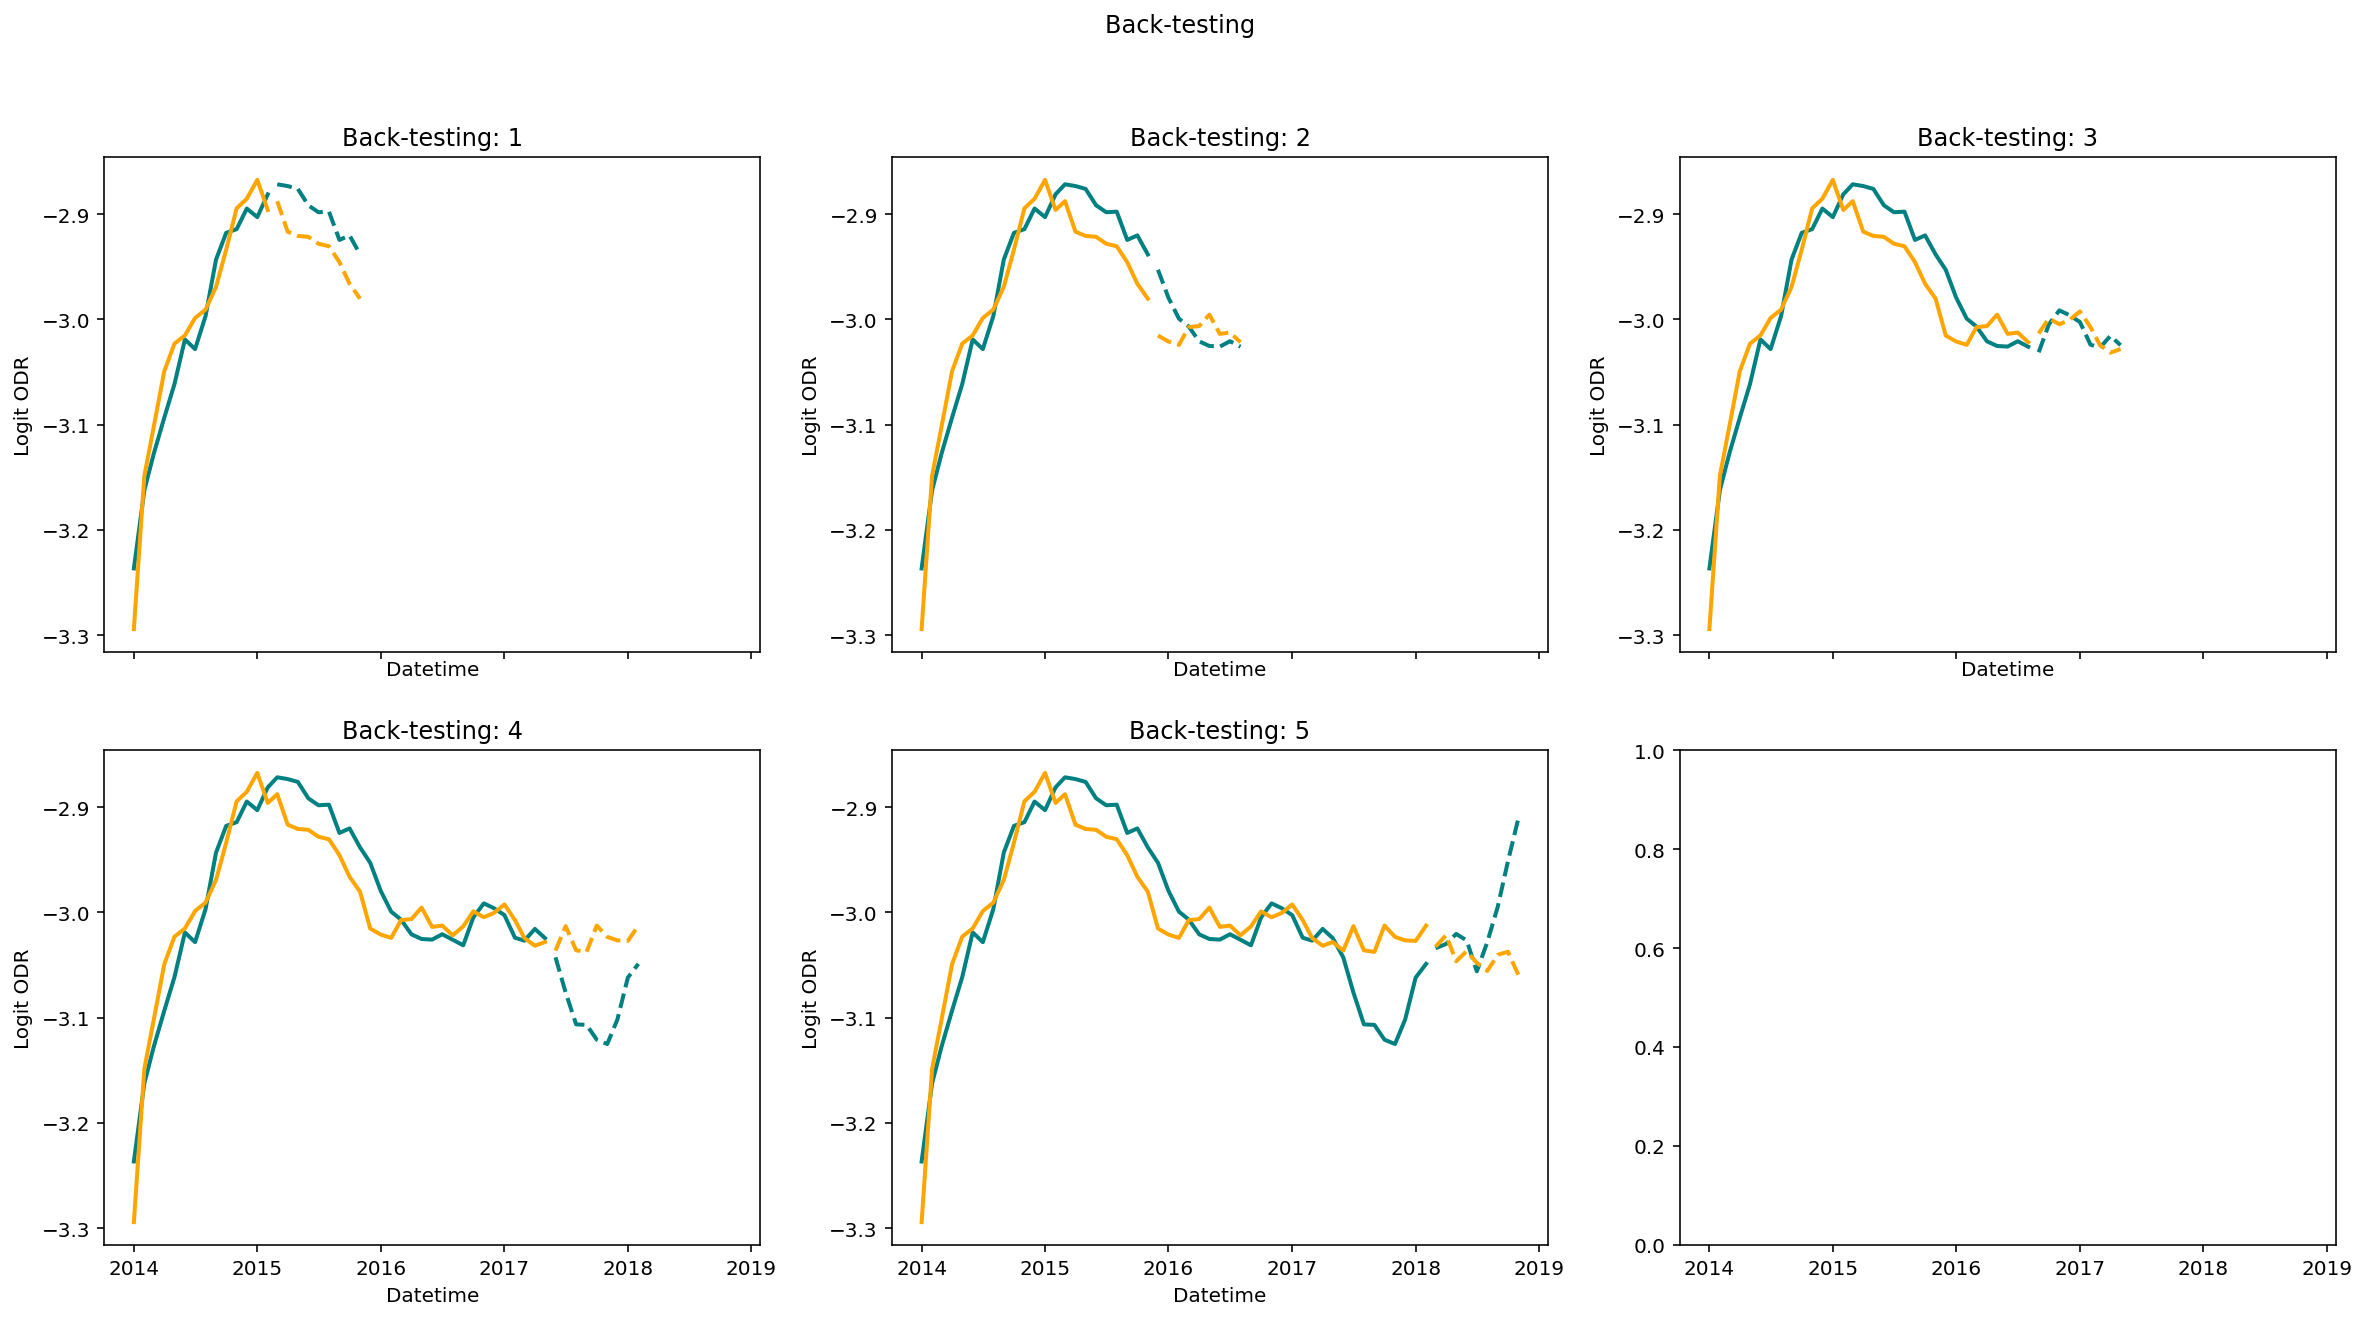

In [18]:
# Fitting model
model = LinearRegression()
model.fit(X[selectedVar], y)

# Time series cross validation
TSCV = TimeSeriesSplit(n_splits = 5)

# Plot
fig, axs = plt.subplots(2, 3, figsize = (20, 10), sharex = True)
fig.suptitle('Back-testing ')
axs = axs.ravel()

for i, (trainIndex, testIndex) in zip(range(TSCV.get_n_splits()), TSCV.split(XStd)):
  # Train/Test split
  XTrain, XTest = X.iloc[trainIndex][selectedVar], X.iloc[testIndex][selectedVar]
  yTrain, yTest = y.iloc[trainIndex], y.iloc[testIndex]
  # Plot
  axs[i].set_title(f'Back-testing: {i + 1}')
  axs[i].plot(
      pd.to_datetime(yTrain.index),
      yTrain,
      color = 'teal',
      linewidth = 2,
      label = 'Actual'
  )
  axs[i].plot(
      pd.to_datetime(yTrain.index),
      model.predict(XTrain),
      color = 'orange',
      linewidth = 2,
      label = 'Predict'
  )
  axs[i].plot(
      pd.to_datetime(yTest.index),
      yTest,
      color = 'teal',
      linewidth = 2, 
      linestyle = '--'
  )
  axs[i].plot(
      pd.to_datetime(yTest.index),
      model.predict(XTest),
      color = 'orange',
      linewidth = 2,
      linestyle = '--'
  )
  axs[i].set(xlabel = 'Datetime', ylabel = 'Logit ODR')
plt.show()